In [53]:
from src.v4.torchdata import print_formatted_table, load_vals, unload_vals
from src.v5.problem import symbolic
from src.v6.problem import MFunctionalSet, MFunctionalSetLeaf
from graph.matrixview import render_incidence
from graph.graphutils import default_tree, all_edges, all_variables
from src.v2.tearing import dir_graph, min_arc_set_assign
from graph.operators import reformulate
from graph.workflow import order_from_tree
from scipy import optimize

In [40]:
S, t, p, d, F, L, D, m, R, r = symbolic('S', 't', 'p', 'd', 'F', 'L', 'D', 'm', 'R', 'r')
Aerodynamics = MFunctionalSetLeaf(
    D == 0.1 * ((S / 360)**2 + 200 + t**2 - t - 4 * d),
    F == 10 * S + 0.2 * t - 0.2 * d,
    L == (S + 0.2 * t - 2 * d) / 3000, idvals=[0,1,2]
)
Structure = MFunctionalSetLeaf(
    m == 4000 * (S / 360)**3 + 200000 + 100 * p + 200 * F,
    R == -3 * S - 6 * p + 0.1 * F + 55,
    d == 2 * S + 3 * p - 2 * F, idvals=[3,4,5]
)
OAD = MFunctionalSetLeaf(
    r == 8e11 * L / (m * D), idvals=[6]
)
FPF = MFunctionalSet(Aerodynamics, Structure, OAD).subsetof(R<=0.5, L>=0.5).minimize(-r)
SPF_MDF = FPF.config(elim=[MFunctionalSet(Aerodynamics, Structure).config(residuals=[Aerodynamics, Structure]), OAD])

In [41]:
f_MDF = SPF_MDF.build()

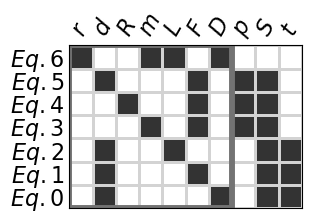

In [42]:
sets,_,_,_,indices = SPF_MDF.gather_sets()
idxrev = {var.item():key for key,var in f_MDF.indices.items()}
in_outs = {key: val.analysis.structure for key,val in sets.items()}
Ein = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[0]) for eqid, item in in_outs.items()}
Eout = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[1]) for eqid, item in in_outs.items()}
edges = Ein, Eout, {}
sorted_keys = sorted(Ein.keys())
tree = default_tree(Ein.keys())
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((3,3)),diagonalgray=False);

In [44]:
graph_edges_minassign = all_edges(*edges)
varidxs = all_variables(*edges)
eqnidxs = list(edges[1].keys())
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [51]:
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_output=['t'])
outset_initial = {comp: var[0] for comp,var in edges[1].items()}
outset_opt = {right:left for left, right in edges_left_right 
                  if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [54]:
str2symb = {str(key):key for key in indices.keys()}
outset_symb = {key:symbolic(str2symb[val])[0] for key,val in outset_opt.items()}
edges_new, tree_new = reformulate(edges, tree, outset_initial, outset_opt, root_solver_name=1)
workflow_order = order_from_tree(tree_new[0], tree_new[1], Eout=edges_new[1])

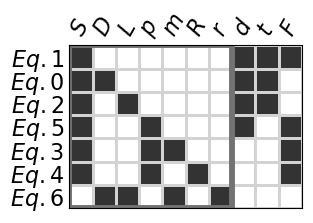

In [56]:
render_incidence(edges_new, tree_new, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((3,3)),diagonalgray=False);

In [57]:
FPFr2 = FPF.reconfigure(outset_symb).config_from_workflow(workflow_order)

In [60]:
f_MDF = FPFr2.build()
x0 = {"S": 10, "p": 1, "t": 5, "d": -298, "F":160.67}
x0_MDA = f_MDF.analysis(load_vals(x0, f_MDF.indices, isdict=True, default=1.1))
for elt in SPF_MDF.supersets:
    fP = elt.build()
    xP = load_vals(unload_vals(x0_MDA, f_MDF.indices), fP.indices, isdict=True)
    print_formatted_table([xP], fP.indices)

L     d    S      t F      D    
0.202 -298 10.007 5 160.67 141.2
d    S      F      p     R      m     
-298 10.007 160.67 1.109 34.394 2.32e5
r        m      L     D    
4936.069 2.32e5 0.202 141.2


In [31]:
f_MDF = SPF_MDF.build()
x0 = {"S": 10, "p": 1, "t": 5, "d": 1000}
x0_MDA = f_MDF.analysis(load_vals(x0, f_MDF.indices, isdict=True, default=1.1))
for elt in SPF_MDF.supersets:
    fP = elt.build()
    xP = load_vals(unload_vals(x0_MDA, f_MDF.indices), fP.indices, isdict=True)
    print_formatted_table([xP], fP.indices)

L     d        S  t F       D      
0.203 -298.333 10 5 160.667 141.333
d        S  F       p R      m     
-298.333 10 160.667 1 35.067 2.32e5
r        m      L     D      
4937.017 2.32e5 0.203 141.333


In [32]:
x0_full = {"S": 10, "p": 1, "t": 5, "d": 1000} # Found a pretty bad error, which is if we initialize the wrong names
obj, dobj, xguess, cons, idxs, solidxs = SPF_MDF.build_opt(x0=x0_full)

In [34]:
xsol = optimize.minimize(obj, xguess, jac=dobj, 
                         constraints=cons, method='SLSQP', bounds=[(1e-3,1000),(1e-3,1000),(1e-3,1000)])#, options={'maxiter':20})
xsol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -4535.630681338327
       x: [ 2.509e+01  3.179e+00  7.282e-01]
     nit: 6
     jac: [ 4.021e+01 -1.859e-01  9.413e-01]
    nfev: 8
    njev: 6

In [35]:
xsol.x

array([25.09306227,  3.17934217,  0.7282326 ])